In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [4]:
image_dir = Path('./images/images/')

In [5]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(500, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [6]:
image_df

,Filepath,Label
0,images\images\gyoza\417638.jpg,gyoza
1,images\images\lasagna\1204012.jpg,lasagna
2,images\images\lasagna\3058483.jpg,lasagna
3,images\images\scallops\1404351.jpg,scallops
4,images\images\french_toast\1421605.jpg,french_toast
...,...,...
50495,images\images\waffles\3396769.jpg,waffles
50496,images\images\mussels\1535130.jpg,mussels
50497,images\images\bruschetta\1933709.jpg,bruschetta
50498,images\images\clam_chowder\2747562.jpg,clam_chowder


In [7]:
image_df['Label'].value_counts()

Label
gyoza                500
mussels              500
cup_cakes            500
peking_duck          500
hot_and_sour_soup    500
                    ... 
foie_gras            500
dumplings            500
tacos                500
croque_madame        500
grilled_salmon       500
Name: count, Length: 101, dtype: int64

In [8]:
image_df['Label'].unique()

array(['gyoza', 'lasagna', 'scallops', 'french_toast', 'prime_rib',
       'beef_tartare', 'beet_salad', 'pad_thai', 'spaghetti_bolognese',
       'greek_salad', 'spaghetti_carbonara', 'pulled_pork_sandwich',
       'lobster_bisque', 'creme_brulee', 'pancakes', 'sashimi',
       'guacamole', 'crab_cakes', 'miso_soup', 'seaweed_salad',
       'onion_rings', 'pork_chop', 'chocolate_mousse', 'poutine',
       'omelette', 'tiramisu', 'samosa', 'hot_dog', 'croque_madame',
       'tacos', 'dumplings', 'foie_gras', 'filet_mignon', 'panna_cotta',
       'eggs_benedict', 'lobster_roll_sandwich', 'red_velvet_cake',
       'chicken_wings', 'edamame', 'bruschetta', 'beignets', 'macarons',
       'chicken_quesadilla', 'chicken_curry', 'hamburger', 'churros',
       'chocolate_cake', 'waffles', 'cheese_plate', 'huevos_rancheros',
       'sushi', 'french_onion_soup', 'bibimbap', 'cheesecake', 'oysters',
       'ramen', 'strawberry_shortcake', 'takoyaki', 'beef_carpaccio',
       'risotto', 'escargots

In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 28280 validated image filenames belonging to 101 classes.
Found 7070 validated image filenames belonging to 101 classes.
Found 15150 validated image filenames belonging to 101 classes.


In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False



9406464/9406464 [==============================] - 4s 0us/step


In [13]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)


Epoch 1/10


884/884 [==============================] - 983s 1s/step - loss: 2.6805 - accuracy: 0.3486 - val_loss: 2.1330 - val_accuracy: 0.4537
Epoch 2/10
884/884 [==============================] - 812s 918ms/step - loss: 1.8692 - accuracy: 0.5118 - val_loss: 1.9746 - val_accuracy: 0.4945
Epoch 3/10
884/884 [==============================] - 528s 597ms/step - loss: 1.6226 - accuracy: 0.5719 - val_loss: 1.9479 - val_accuracy: 0.5044
Epoch 4/10
884/884 [==============================] - 442s 500ms/step - loss: 1.4348 - accuracy: 0.6106 - val_loss: 1.9341 - val_accuracy: 0.5105
Epoch 5/10
884/884 [==============================] - 687s 778ms/step - loss: 1.2833 - accuracy: 0.6498 - val_loss: 1.9607 - val_accuracy: 0.5221
Epoch 6/10
884/884 [==============================] - 616s 697ms/step - loss: 1.1476 - accuracy: 0.6790 - val_loss: 2.0716 - val_accuracy: 0.5123
Epoch 7/10
884/884 [==============================] - 416s 471ms/step - loss: 1.0333 - accuracy: 0.7043 - val_loss: 2.0885 -

In [15]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 50.60%


In [30]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)
print("Prediction", predictions)

474/474 [==============================] - 732s 2s/step
Prediction [24 49 63 ... 14 90  0]


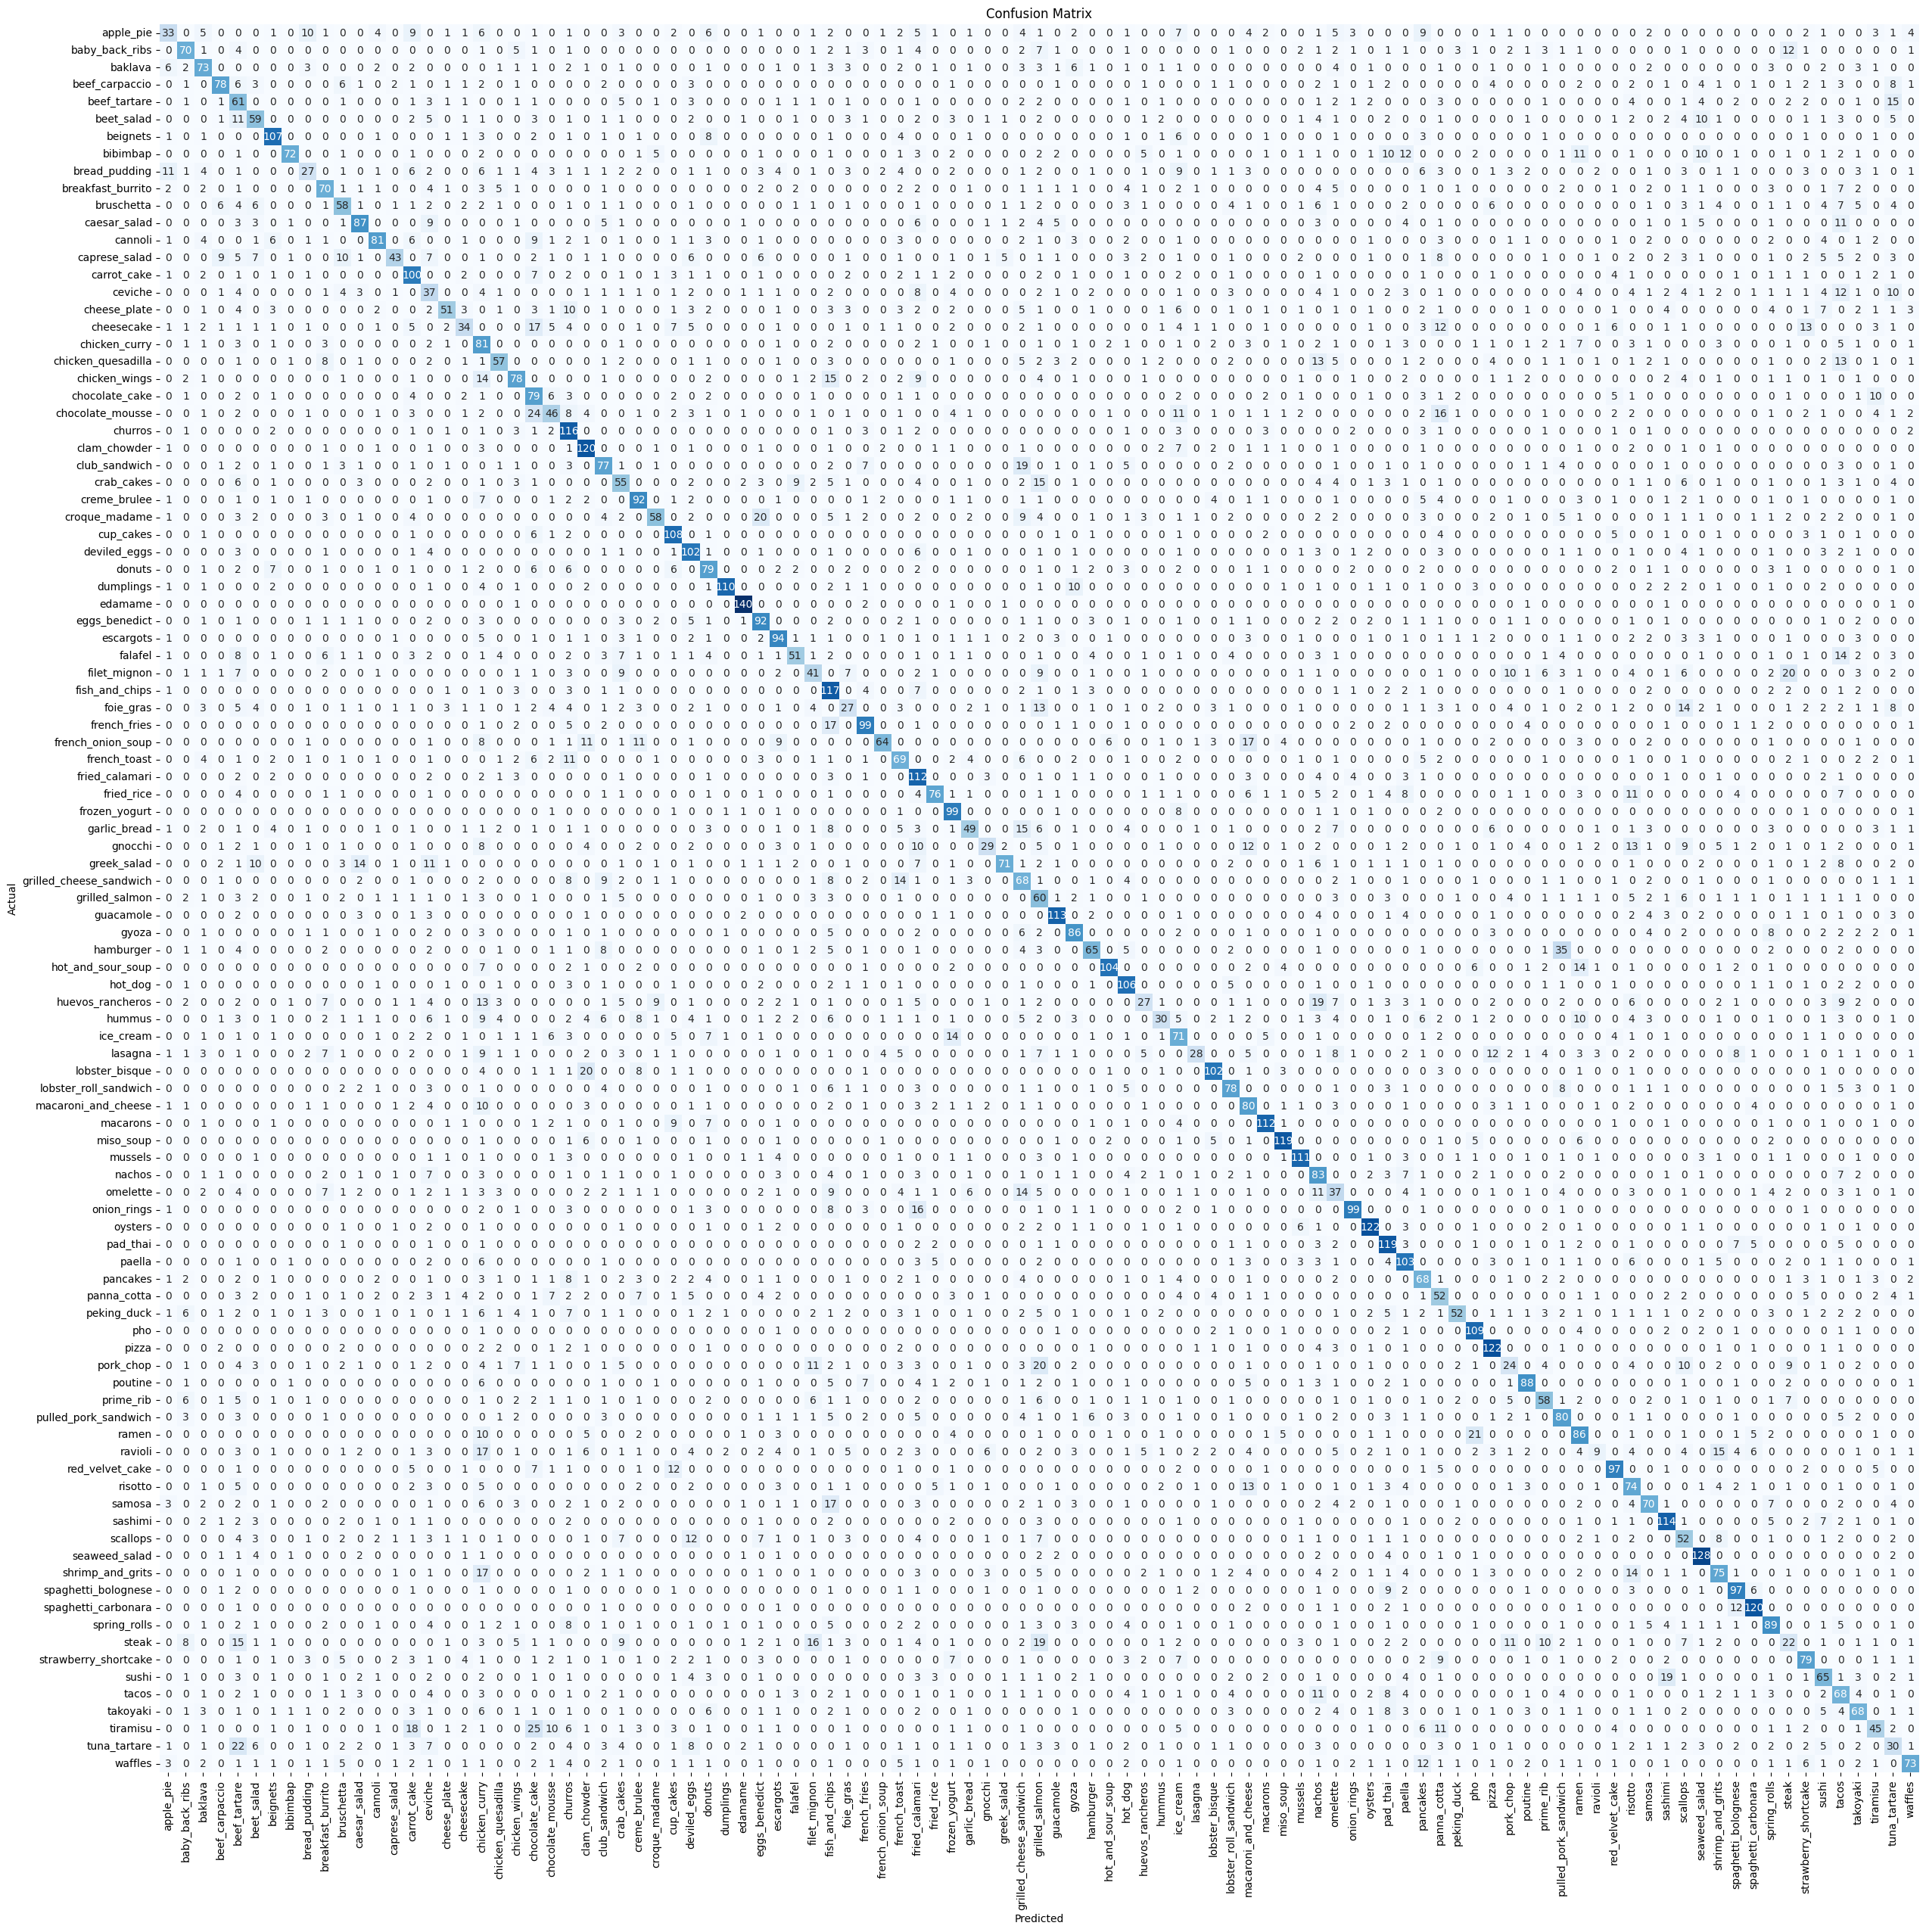

In [17]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [29]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.43      0.22      0.29       152
         baby_back_ribs       0.59      0.49      0.54       142
                baklava       0.53      0.51      0.52       144
         beef_carpaccio       0.70      0.52      0.60       150
           beef_tartare       0.22      0.46      0.30       133
             beet_salad       0.47      0.40      0.44       146
               beignets       0.68      0.71      0.69       150
               bibimbap       0.90      0.46      0.61       158
          bread_pudding       0.40      0.18      0.25       147
      breakfast_burrito       0.49      0.48      0.49       145
             bruschetta       0.45      0.38      0.41       153
           caesar_salad       0.62      0.55      0.58       158
                cannoli       0.70      0.53      0.60       152
          caprese_salad       0.70      0.

In [ ]:
model.save('Mobilenet_V2_trained_101class.hdf5')